# Time Series

This example demonstrates operator learning for a time series with non-uniform
time steps. Actually, a discretization-invariant neural operator can learn
from an arbitrary discretization and generalize to a different one!

In [1]:
import torch
import matplotlib.pyplot as plt
torch.manual_seed(0)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)
plt.rcParams["legend.framealpha"] = 0.0

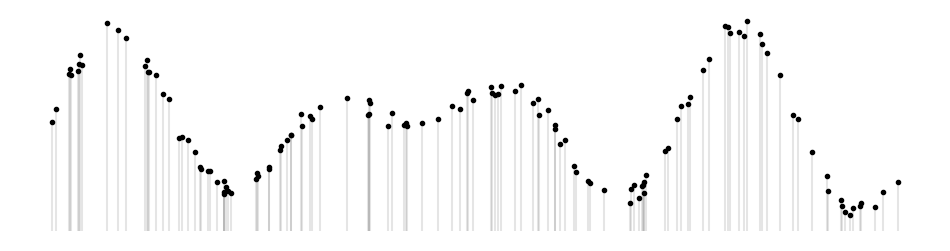

In [2]:
t = torch.rand(128) * 4
f = 0.5 * (torch.sin(2 * torch.pi * t) + torch.sin(1.4 * torch.pi * t) + torch.rand_like(t) * 0.4) + 1

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(t, f, "k.")
for i, t in enumerate(t):
    ax.vlines(t, 0, f[i], color="k", alpha=0.1)
ax.axis("off")
plt.show()

## Setup

In [3]:
import torch
import matplotlib.pyplot as plt
from continuity.operators import BelNet
from continuity.data import OperatorDataset
from continuity.trainer import Trainer

## Problem

As a simple demonstration of the concepts, we will consider sequences of $n$
observations $f_i$ with $i \in \{1, \dots, n\}$. The index $i$ corresponds to
samples of a function $f$ at times $t_i$. For these observations, we would
like to predict $m$ future values $f_j$ where $j \in \{n+1, \dots, n+m\}$.

In this example, we choose a simple sine function

$$
f(t) = \sin(2\pi t),
$$

and choose $n=32$ and $m = 16$. Both $t_i$ and $t_j$ are sampled random
uniformly from the intervals $t_i\in [0, 1)$ and $t_j\in [1, 1.5)$.

The trained neural operator is supposed to predict the future of the time series
by only having access to $n$ evaluations of the historical function.

In [4]:
f = lambda t: torch.sin(2 * torch.pi * t)

def random_locations(num_sensors):
    return torch.sort(torch.rand(num_sensors))[0]

# History will be given as input
num_sensors = 32
t_hist = random_locations(num_sensors)

# Future will be given as labels
num_labels = 16
t_fut = 1 + 0.5 * random_locations(num_labels)

f_hist = f(t_hist)
f_fut = f(t_fut)

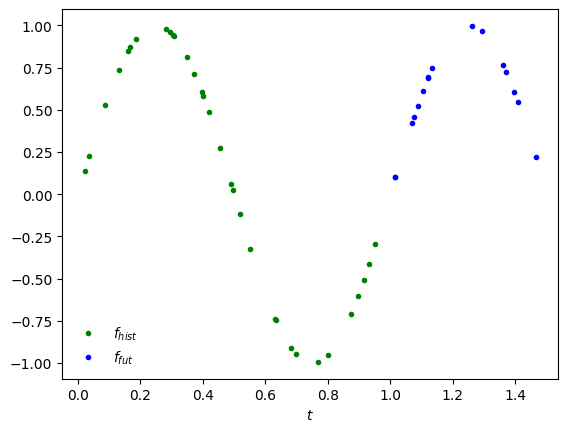

In [5]:
plt.plot(t_hist, f_hist, "g.", label=r"$f_{hist}$")
plt.plot(t_fut, f_fut, "b.", label=r"$f_{fut}$")
plt.xlabel(r"$t$")
plt.legend()
plt.show()

## Dataset

For training an operator, we first construct the corresponding `OperatorDataset`.

In [6]:
n_samples = 1
x_dim = u_dim = y_dim = v_dim = 1

x = t_hist.reshape(n_samples, num_sensors, x_dim)
u = f_hist.reshape(n_samples, num_sensors, u_dim)
y = t_fut.reshape(n_samples, num_labels, y_dim)
v = f_fut.reshape(n_samples, num_labels, v_dim)

dataset = OperatorDataset(x, u, y, v)

## Operator

In this example, we use [BelNet](https://arxiv.org/pdf/2212.07336.pdf), a
discretization-invariant neural operator that can interpolate between different
input discretizations.
It can also learn mappings of functions that are defined on different domains,
this is what is referred to as domain-independence.

In [7]:
operator = BelNet(dataset.shapes, K=8, D_1=16, D_2=16)

## Training

We train the operator on the given input discretization.

In [8]:
Trainer(operator).fit(dataset, tol=1e-5)

Model parameters: 41512
Device: mps
Epoch 528:  loss/train = 9.9556e-06  (0.028 s/epoch)


## Evaluation

Let's plot the predictions of the trained BelNet on the interval $[1, 1.5)$.
Note that the operator makes a good prediction even if we sample the sine wave
in new random time steps!

In [9]:
t_plot = torch.linspace(1, 1.5, 100).reshape(1, -1, 1)

# Time steps used for training
f_pred = operator(x, u, t_plot)    # x, u = t_hist, f_hist

# Different time steps
t_hist2 = random_locations(num_sensors)
f_hist2 = f(t_hist2)
x2 = t_hist2.reshape(1, -1, 1)
u2 = f_hist2.reshape(1, -1, 1)
f_pred2 = operator(x2, u2, t_plot) # x2, u2 = t_hist2, f_hist2

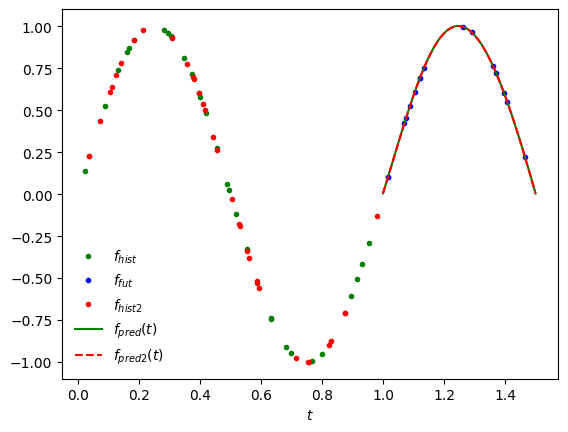

In [10]:
# Plot inputs and predictions
plt.plot(x.squeeze(), u.squeeze(), "g.", label=r"$f_{hist}$")
plt.plot(t_fut, f_fut, "b.", label=r"$f_{fut}$")
plt.plot(x2.squeeze(), u2.squeeze(), "r.", label=r"$f_{hist2}$")
plt.plot(t_plot.squeeze(), f_pred.squeeze().detach(), "g-", label=r"$f_{pred}(t)$")
plt.plot(t_plot.squeeze(), f_pred2.squeeze().detach(), "r--", label=r"$f_{pred2}(t)$")
plt.xlabel(r"$t$")
plt.legend()
plt.show()

This example demonstrates how useful it can be to consider functional
data as functions and apply machine learning to these functions directly.
This is what operator learning is about!